<a href="https://colab.research.google.com/github/zhaxylykbayeva/msis/blob/main/Graduate%20School%20Admissions%20project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chance of Admission into Graduate School Prediction Model Analysis

## Dataset Description

The dataset I will be using for this analysis is from Kaggle and can be accessed here: https://www.kaggle.com/mohansacharya/graduate-admissions


The dataset contains several parameters which are considered important during the application for Masters Programs. 
It has 400 records.

As described on kaggle, this dataset was created to help students shortlist universities they should apply to, based on their profile. It could also help those who are preparing to apply to strengthen their test scores or other application materials, depending on University rating they want to get into.

#### Column names and description:

        - Serial No.
        - GRE Score
        - TOEFL Score
        - University Rating
        - SOP (Statement of Purpose strength)
        - LOR (Letter of Recommendation strength)
        - CGPA (Undergraduate CGPA)
        - Research
        - Chance of Admit 
        
Research column is binary, and the rest are numeric - either floats or integers.

## Read in and Clean Dataset

In [ ]:
#reading in my dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import norm

dataset = '/Users/Allie/Desktop/MSIS/502 - Elasady/graduate-admissions/Admission_Predict.csv'
adm_predict = pd.read_csv(dataset, sep =',', header=0)

In [ ]:
#Removing spaces in column names
def cleanheaders(data,x):
    data.columns=data.columns.str.replace(x, "")
    return(data[:0])

cleanheaders(adm_predict," ")

,SerialNo.,GREScore,TOEFLScore,UniversityRating,SOP,LOR,CGPA,Research,ChanceofAdmit


In [ ]:
#dropping unnecessary column as it just contains index for each row, and does not provide any
#useful information for the analysis

adm_predict = adm_predict.drop(["SerialNo."], axis = 1)

In [ ]:
#drop rows that have over 3 missing values

adm_predict = adm_predict.dropna(thresh=3)

## Exploratory Data Analysis

In [ ]:
adm_predict.describe()

,GREScore,TOEFLScore,UniversityRating,SOP,LOR,CGPA,Research,ChanceofAdmit
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,316.807500,107.410000,3.087500,3.400000,3.452500,8.598925,0.547500,0.724350
std,11.473646,6.069514,1.143728,1.006869,0.898478,0.596317,0.498362,0.142609
min,290.000000,92.000000,1.000000,1.000000,1.000000,6.800000,0.000000,0.340000
25%,308.000000,103.000000,2.000000,2.500000,3.000000,8.170000,0.000000,0.640000
50%,317.000000,107.000000,3.000000,3.500000,3.500000,8.610000,1.000000,0.730000
75%,325.000000,112.000000,4.000000,4.000000,4.000000,9.062500,1.000000,0.830000
max,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000,0.970000


In [ ]:
#create a copy of my dataframe, so that I always have access to the original if needed.
linregdf = adm_predict[["GREScore","TOEFLScore","UniversityRating","SOP","LOR","CGPA","Research","ChanceofAdmit"]]

In [ ]:
#Make sure all the values are actually numerical before standardizing them
linregdf.dtypes

GREScore              int64
TOEFLScore            int64
UniversityRating      int64
SOP                 float64
LOR                 float64
CGPA                float64
Research              int64
ChanceofAdmit       float64
dtype: object

In [ ]:
# standardize each numeric using MinMax, according to the columns distribution
from sklearn import preprocessing 
minmax_scaler = preprocessing.MinMaxScaler()
linregdf_minmax = pd.DataFrame(minmax_scaler.fit_transform(linregdf))

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


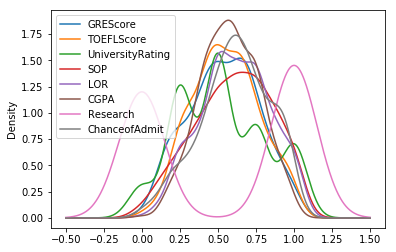

In [ ]:
linregdf_minmax.columns=["GREScore","TOEFLScore","UniversityRating","SOP","LOR","CGPA","Research","ChanceofAdmit"]
linregdf_minmax.plot(kind='density')

In [ ]:
#testing GRE Score for normality

from scipy.stats import shapiro

W_stat, p = shapiro(adm_predict.GREScore)
print("W-statistic= {}, Pvalue= {}".format(W_stat, p))

alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

W-statistic= 0.9857197403907776, Pvalue= 0.0005621708696708083
Sample does not look Gaussian (reject H0)


In [ ]:
#Testing TOEFL Score for normality

W_stat, p = shapiro(adm_predict.TOEFLScore)
print("W-statistic= {}, Pvalue= {}".format(W_stat, p))

alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

W-statistic= 0.9873192310333252, Pvalue= 0.0014660957967862487
Sample does not look Gaussian (reject H0)


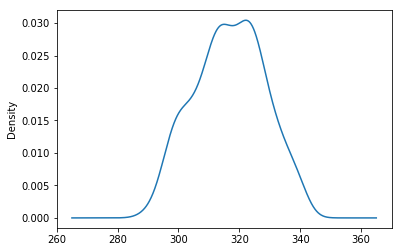

In [ ]:
#I want to take a look at several density plots to further plan what to do in this analysis

%matplotlib inline
adm_predict.GREScore.plot(kind='density')de86

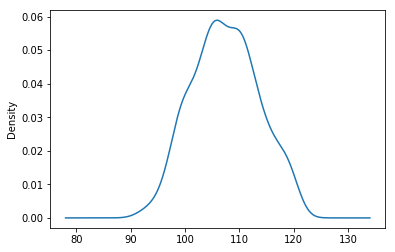

In [ ]:
adm_predict.TOEFLScore.plot(kind='density')

Text(0.5, 1.0, 'TOEFL Score')

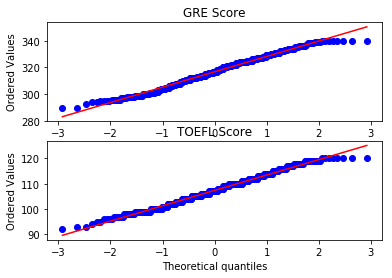

In [ ]:
import scipy.stats as stats

fig = plt.figure()
ax = fig.add_subplot(211)
stats.probplot(adm_predict.GREScore, dist="norm", plot=plt)
ax.set_title("GRE Score")

ax = fig.add_subplot(212)
stats.probplot(adm_predict.TOEFLScore, dist="norm", plot=plt)
ax.set_title("TOEFL Score")

I will now examine if there is any linear relationship between my target and features, as well as examine correlation of columns.

In [ ]:
#Creating my dataframes for linear regression

df_x = pd.DataFrame(linregdf_minmax,
                 columns=["GREScore","TOEFLScore","UniversityRating","SOP","LOR","CGPA","Research"])

df_y = pd.DataFrame(linregdf_minmax,
                   columns=["ChanceofAdmit"])

Text(0.5, 1.0, 'GRE Score and Chance of Admission')

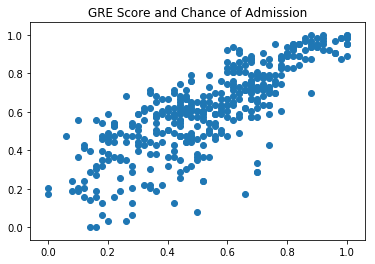

In [ ]:
plt.scatter(df_x.GREScore, df_y.ChanceofAdmit)
plt.title("GRE Score and Chance of Admission")

Text(0.5, 1.0, 'TOEFL Score and Chance of Admission')

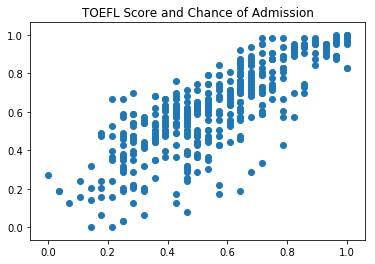

In [ ]:
plt.scatter(df_x.TOEFLScore, df_y.ChanceofAdmit)
plt.title("TOEFL Score and Chance of Admission")

Text(0.5, 1.0, 'University Rating and Chance of Admission')

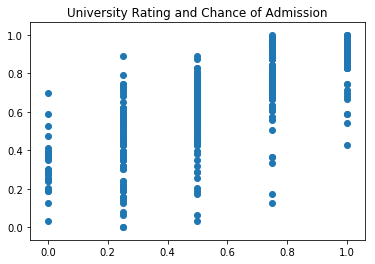

In [ ]:
plt.scatter(df_x.UniversityRating, df_y.ChanceofAdmit)
plt.title("University Rating and Chance of Admission")

Text(0.5, 1.0, 'Statement of Purpose and Chance of Admission')

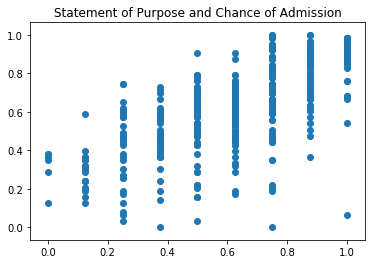

In [ ]:
plt.scatter(df_x.SOP, df_y.ChanceofAdmit)
plt.title("Statement of Purpose and Chance of Admission")

Text(0.5, 1.0, 'Letter of Recommendation and Chance of Admission')

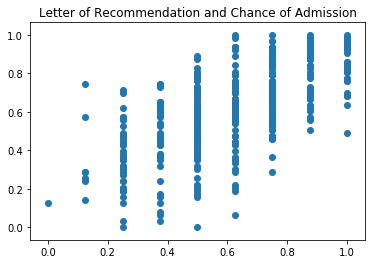

In [ ]:
plt.scatter(df_x.LOR, df_y.ChanceofAdmit)
plt.title("Letter of Recommendation and Chance of Admission")

Text(0.5, 1.0, 'Undergraduate Cumulative GPA and Chance of Admission')

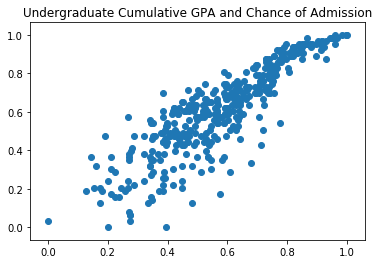

In [ ]:
plt.scatter(df_x.CGPA, df_y.ChanceofAdmit)
plt.title("Undergraduate Cumulative GPA and Chance of Admission")

Text(0.5, 1.0, 'Research Experience and Chance of Admission')

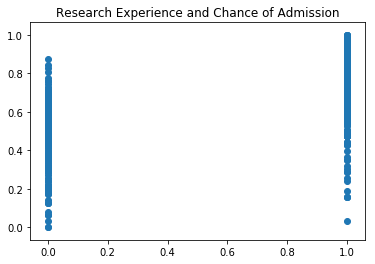

In [ ]:
plt.scatter(df_x.Research, df_y.ChanceofAdmit)
plt.title("Research Experience and Chance of Admission")

In [ ]:
df_x=df_x[["GREScore","TOEFLScore","UniversityRating","SOP","LOR","CGPA"]]

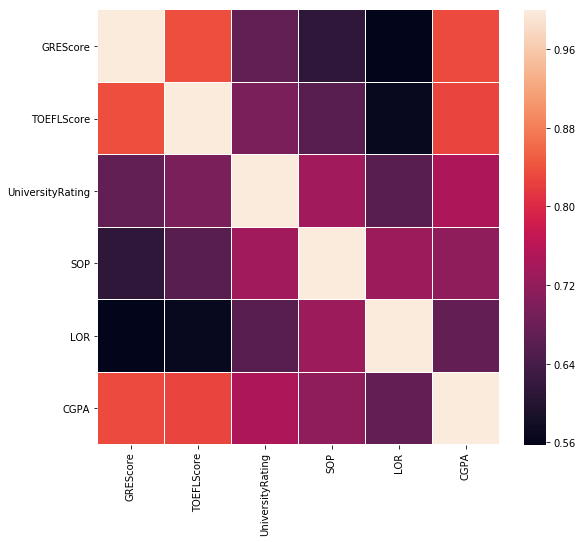

In [ ]:
corr_mat = df_x.corr()

f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corr_mat, ax = ax, linewidths = 0.1) 

In [ ]:
#further examining columns with higher 
df_x[["GREScore","UniversityRating","SOP","LOR"]].corr()

,GREScore,UniversityRating,SOP,LOR
GREScore,1.000000,0.668976,0.612831,0.557555
UniversityRating,0.668976,1.000000,0.734523,0.660123
SOP,0.612831,0.734523,1.000000,0.729593
LOR,0.557555,0.660123,0.729593,1.000000


In [ ]:
df_x = df_x.drop(["TOEFLScore","CGPA"], axis=1)

Since everything has been scaled, as well as data was clean to begin with, there are no outliers to take care of.

## Linear Regression (or supplement with another appropriate model) (20 points)

#### Leaving 20% of the data for testing and training my model

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y,  
                                                   test_size=0.2,
                                                   random_state=15)

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True,
                        n_jobs=6)

In [ ]:
fit = model.fit(x_train, y_train)

In [ ]:
fit_coef = fit.coef_.T
fit_coef.tolist

<function ndarray.tolist>

In [ ]:
coef_df = pd.DataFrame([df_x.columns[:4], fit_coef]).T
coef_df.columns = ["feature", "coeff"]
coef_df

,feature,coeff
0,GREScore,[0.5339499605468826]
1,UniversityRating,[0.11014798587852996]
2,SOP,[0.08784680053267933]
3,LOR,[0.20141660209057857]


In [ ]:
preds = model.predict(x_test)

Text(0, 0.5, 'Predictions')

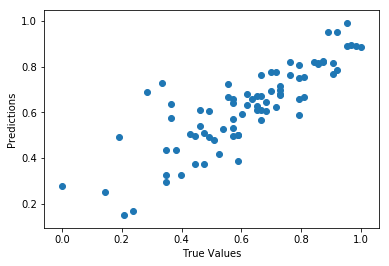

In [ ]:
plt.scatter(y_test, preds)
plt.xlabel("True Values")
plt.ylabel("Predictions")

Text(0, 0.5, 'Residuals')

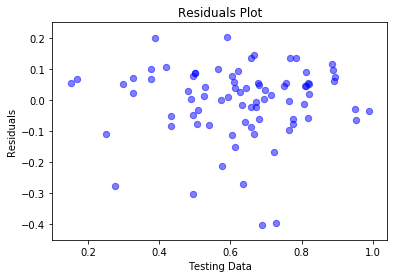

In [ ]:
residuals = y_test - preds
plt.scatter(model.predict(x_test), residuals,
            c='b', s=40, alpha=0.5) # plot x_test vs residuals
plt.title("Residuals Plot")
plt.xlabel("Testing Data")
plt.ylabel("Residuals")

## Conclusion

1. Correlation Plot for the features ( In[26] ) showed that all of the data were positively correlated with each other, with the lowest correlation being at about 0.56. Three features - GRE Score, TOEFL Score, and Undergrad GPA were correalted the highest. Because of such strong correlation, I only kept GRE Score column, because it seemed the most relevant to reduce multicollinearity.

2. Residuals Plot showed no pattern, which indicates that the features we used are explaining the dependent variable well. Testing normality below to ensure this conclusion:

In [ ]:
W_stat, p = shapiro(residuals)
print("W-statistic= {}, Pvalue= {}".format(W_stat, p))

alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

W-statistic= 0.8995780348777771, Pvalue= 1.1689221537380945e-05
Sample does not look Gaussian (reject H0)


According to Residuals normality testing, sample does not look Gaussian, however visually I could not detect an obvious pattern.

In [ ]:
#Calculate R2 to test one last time the reliability of the analysis conducted above

from sklearn.metrics import r2_score
r2_score(y_test, preds)

0.7072401722624448

3. Calculated above, R^2 is high and indicates over 70% of the variation in the dependent variable is explained by variation in the features.

4. Regression coefficient on the GRE Score indicates that an increase in GRE Score by 1 standard deviation improves your predicted chances by 0.5 standard deviation. Some other predictors like strength of Letter of Recommendation or Statement of Purpose are also positively correlated with Chance of Admission, but to a lesser extent.    Interestingly, University Rating is also positively correlated with Chance of Admission, which seems a little counterintuitive, because one would think it is harder to get into higher ranked schools. The only explanation for this is that students with better profiles apply to nicer schools.

5. Although GRE Score and TOEFL Score failed Shapiro-Wilks normality test and were identified as not normal distribution, QQ plot has demostrated that both of the features are normal. One of the reasons normality test failed could have been non-continuity of the scores - the scale for GRE and TOEFL scores is not continuous. TOEFL ranges from 92 to 120 in this dataset and GRE ranges from 290 to 340. 

Overall, this dataset fulfills its described purpose well and is mostly accurately able to predict schools worth applying to and offer help gauging chances of getting in. The pool of obesrvations is very limited, so there is some bias present in predictions.